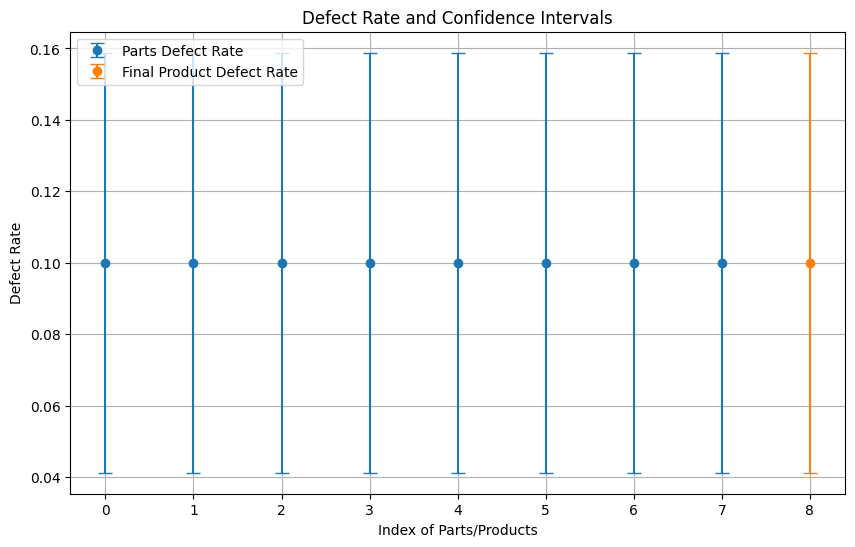

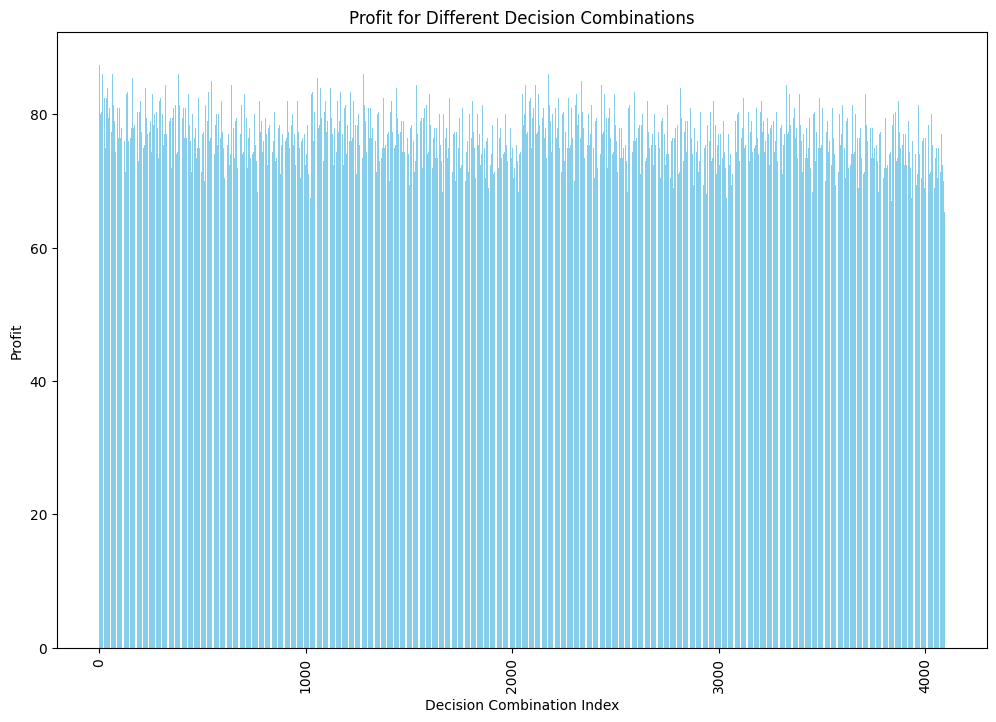

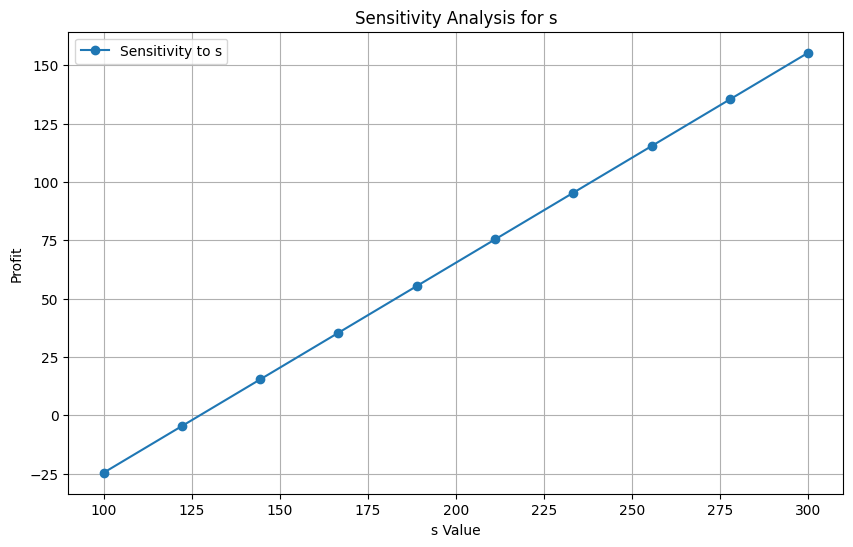

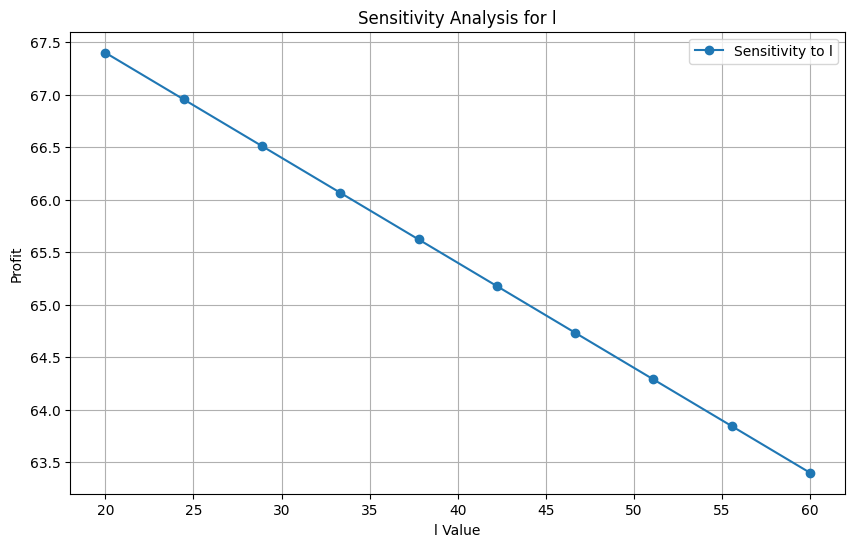

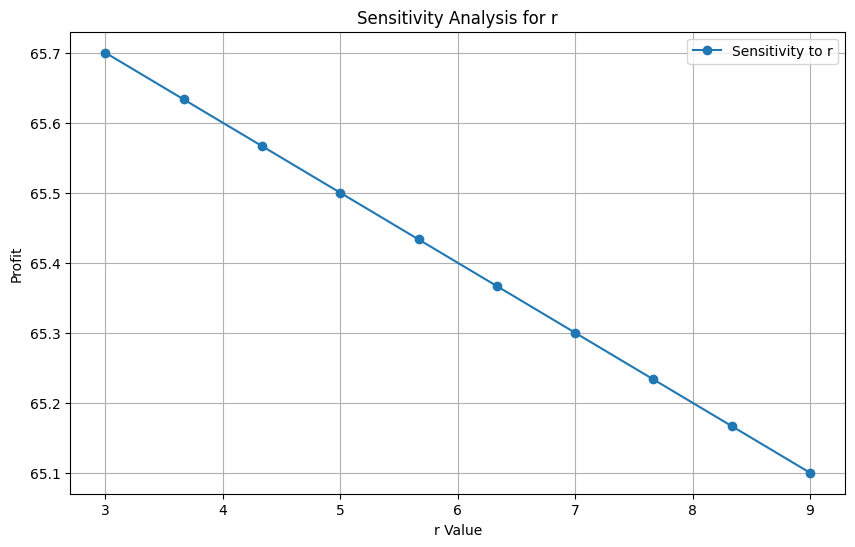

      D0  D1  D2  D3  D4  D5  D6  D7  C0  C1  C2  R  Profit
0      0   0   0   0   0   0   0   0   0   0   0  0    88.0
1      0   0   0   0   0   0   0   0   0   0   0  1    87.4
2      0   0   0   0   0   0   0   0   0   0   1  0    84.0
3      0   0   0   0   0   0   0   0   0   0   1  1    83.4
4      0   0   0   0   0   0   0   0   0   1   0  0    84.0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  .. ..     ...
4091   1   1   1   1   1   1   1   1   1   0   1  1    69.4
4092   1   1   1   1   1   1   1   1   1   1   0  0    70.0
4093   1   1   1   1   1   1   1   1   1   1   0  1    69.4
4094   1   1   1   1   1   1   1   1   1   1   1  0    66.0
4095   1   1   1   1   1   1   1   1   1   1   1  1    65.4

[4096 rows x 13 columns]


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.stats import norm

# 参数设定
params = {
    'm': 8,  # 零配件数量
    'n': 3,  # 半成品数量
    'p_hat': [0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10, 0.10],  # 零配件次品率估计
    'c': [2, 8, 12, 2, 8, 12, 8, 12],  # 购买单价
    'd': [1, 1, 2, 1, 1, 2, 1, 2],  # 零配件检测成本
    'd_assembly': [3, 4, 4],  # 半成品检测成本
    'a': [8, 8, 8],  # 装配成本
    'pf_hat': 0.10,  # 成品次品率估计
    's': 200,  # 市场售价
    'l': 40,  # 调换损失
    'r': 6,  # 拆解费用
    'alpha': 0.05,  # 显著性水平
    'sample_size': 100  # 样本量
}

# 计算置信区间
Z_alpha_2 = norm.ppf(1 - params['alpha'] / 2)
p_errors = [Z_alpha_2 * np.sqrt(ph * (1 - ph) / params['sample_size']) for ph in params['p_hat']]
pf_error = Z_alpha_2 * np.sqrt(params['pf_hat'] * (1 - params['pf_hat']) / params['sample_size'])

# 利润计算函数
def calculate_profit(D, C, R, params):
    cost_parts = sum(params['c'][i] + params['d'][i] * D[i] for i in range(params['m']))
    cost_subassemblies = sum(params['a'][j] + params['d_assembly'][j] * C[j] for j in range(params['n']))
    revenue = params['s'] * (1 - params['pf_hat'])
    cost_rework = params['r'] * R * params['pf_hat']
    loss_replacement = params['l'] * params['pf_hat']
    profit = revenue - cost_parts - cost_subassemblies - cost_rework - loss_replacement
    return profit

# 遍历所有可能的决策组合
profits = []
decision_combinations = list(itertools.product([0, 1], repeat=params['m'] + params['n'] + 1))
for combo in decision_combinations:
    D = combo[:params['m']]
    C = combo[params['m']:params['m'] + params['n']]
    R = combo[-1]
    profit = calculate_profit(D, C, R, params)
    profits.append(profit)

# 转换为DataFrame以便可视化
df = pd.DataFrame(decision_combinations, columns=[f'D{i}' for i in range(params['m'])] + [f'C{j}' for j in range(params['n'])] + ['R'])
df['Profit'] = profits

# 绘制次品率置信区间图
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(params['p_hat'])), params['p_hat'], yerr=p_errors, fmt='o', capsize=5, label='Parts Defect Rate')
plt.errorbar([len(params['p_hat'])] * 1, [params['pf_hat']], yerr=[pf_error], fmt='o', capsize=5, label='Final Product Defect Rate')
plt.xlabel('Index of Parts/Products')
plt.ylabel('Defect Rate')
plt.title('Defect Rate and Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()

# 绘制决策方案对利润的影响图
plt.figure(figsize=(12, 8))
plt.bar(df.index, df['Profit'], color='skyblue')
plt.xlabel('Decision Combination Index')
plt.ylabel('Profit')
plt.title('Profit for Different Decision Combinations')
plt.xticks(rotation=90)
plt.show()

# 敏感性分析图
sensitivity_params = ['s', 'l', 'r']
for param in sensitivity_params:
    values = np.linspace(0.5, 1.5, 10) * params[param]
    profits_sensitivity = [calculate_profit([1]*params['m'], [1]*params['n'], 1, {**params, param: value}) for value in values]
    plt.figure(figsize=(10, 6))
    plt.plot(values, profits_sensitivity, marker='o', label=f'Sensitivity to {param}')
    plt.xlabel(f'{param} Value')
    plt.ylabel('Profit')
    plt.title(f'Sensitivity Analysis for {param}')
    plt.legend()
    plt.grid(True)
    plt.show()


# 打印所有可能的决策组合和利润
print(df)
